# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is on thing or another (there can be multiple things as the options).

Book version of this notebook: https://www.learnpytorch.io/02_pytorch_classification/

All other resources - https://github.com/mrdbourke/pytorch-deep-learning

## 1. Make classification data and get it ready

In [37]:
import sklearn


In [38]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)


In [39]:
len(X), len(y)


(1000, 1000)

In [40]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")


First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [41]:
# Make DataFrame or circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


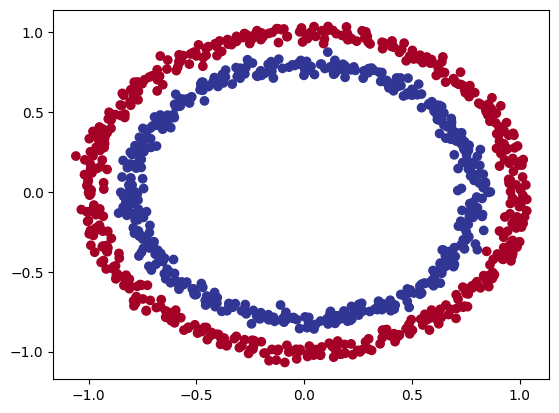

In [42]:
# Visualize, Visualize,Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)


**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizable enough to practice the fundamentals

### 1.1 Check input and output shapes

In [43]:
X.shape, y.shape


((1000, 2), (1000,))

In [44]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(
    f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}"
)


Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [45]:
import torch

torch.__version__


'1.13.0+cu117'

In [46]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [47]:
type(X), X.dtype, y.dtype


(torch.Tensor, torch.float32, torch.float32)

In [48]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [49]:
len(X_train), len(X_test), len(y_train), len(y_test)


(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify out blue and red dots.

To do so, we want to:
1. Setup device agnostic code so out code will run on an acceleratior (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop


In [50]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

Now we've setup device agnostic code, let's create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outline the forward pass (or forward computation ) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [51]:
# 1. Construct a model that sublclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(
            in_features=2, out_features=5
        )  # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(
            in_features=5, out_features=1
        )  # takes in 5 features from the previous layer and outputs a single feature (same shape as y)

    # 3. Define a forward() method that outlines the forward path
    def forward(self, x):
        # x-> layer_1 -> layer_2 -> output
        return self.layer_2(self.layer_1(x))


# 4. Instantiate an instance of our model class and send it to the target device

model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [52]:
next(model_0.parameters()).device


device(type='cuda', index=0)

In [53]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5), nn.Linear(
        in_features=5, out_features=1)
).to(device)

model_0


Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [54]:
model_0.state_dict()


OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [55]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(
    f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n {torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
 tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [56]:
X_test[:10], y_test[:10]


(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup Loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error)

For classification you might want binary cross entropy  or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and usefula are SDG and Adam, however PyTorch has many built-in options.

* For some common choices of loss functions and optimizers - https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer
* For the loss function we're going to use `torch.nn.BECWithLogitsLoss()` https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* For a definition on what a logit is in deep learning - https://stackoverflow.com/a/52111173/7900723
* For different optimizers see `torch.optim`

In [57]:
# Setup the loss function
# loss_fn = nn.BCELoss # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = (
    nn.BCEWithLogitsLoss()
)  # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


In [58]:
model_0.state_dict()


OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [59]:
# Calculate accuracy - out of a 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


## 3. Train Model

To train our model , we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Loss backwards (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> predictions probabilities -> prediction labels

Our model output are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function(e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's predictions probabilities to prediction labels by either rounding them or taking the argmax().


In [60]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits


tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [61]:
y_test[:5]


tensor([1., 0., 1., 0., 1.])

In [62]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs


tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probalility values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5 `y=1` (class 1)
* `y_pred_probs` < 0.5 `y=0` (class 0)

In [63]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In Full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()


tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

In [64]:
y_test[:5]


tensor([1., 0., 1., 0., 1.])

# 3.2 Building a training and testing loop

In [65]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to the target device
X_train, y_train, = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training an evaluation loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # 1. Forward Pass
    y_logits = model_0(X_train).squeeze()
    # turn logits -> pred probs -> pred lables
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits,  # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backward (packpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)

        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69796, Acc: 51.88% | Test loss: 0.69440, Test acc: 58.00%
Epoch: 10 | Loss: 0.69590, Acc: 51.25% | Test loss: 0.69305, Test acc: 53.00%
Epoch: 20 | Loss: 0.69490, Acc: 51.62% | Test loss: 0.69254, Test acc: 49.50%
Epoch: 30 | Loss: 0.69435, Acc: 51.12% | Test loss: 0.69236, Test acc: 49.50%
Epoch: 40 | Loss: 0.69401, Acc: 50.88% | Test loss: 0.69232, Test acc: 51.00%
Epoch: 50 | Loss: 0.69378, Acc: 50.25% | Test loss: 0.69234, Test acc: 50.00%
Epoch: 60 | Loss: 0.69362, Acc: 50.00% | Test loss: 0.69239, Test acc: 51.50%
Epoch: 70 | Loss: 0.69351, Acc: 50.25% | Test loss: 0.69246, Test acc: 51.00%
Epoch: 80 | Loss: 0.69342, Acc: 49.88% | Test loss: 0.69254, Test acc: 50.00%
Epoch: 90 | Loss: 0.69336, Acc: 49.88% | Test loss: 0.69262, Test acc: 53.00%
Epoch: 100 | Loss: 0.69331, Acc: 49.25% | Test loss: 0.69271, Test acc: 53.00%
Epoch: 110 | Loss: 0.69327, Acc: 49.75% | Test loss: 0.69279, Test acc: 54.00%
Epoch: 120 | Loss: 0.69324, Acc: 50.25% | Test loss: 0.69286, T

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything

So to inspect it let's make some predictions and make them visual!

In other words "Visualize, visualize, visualize!"

To do so, we're going to import a function called `plot_decision_boundry()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py


In [66]:
import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo (if it's not already downloaded)
if Path('helper_functions.py').is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


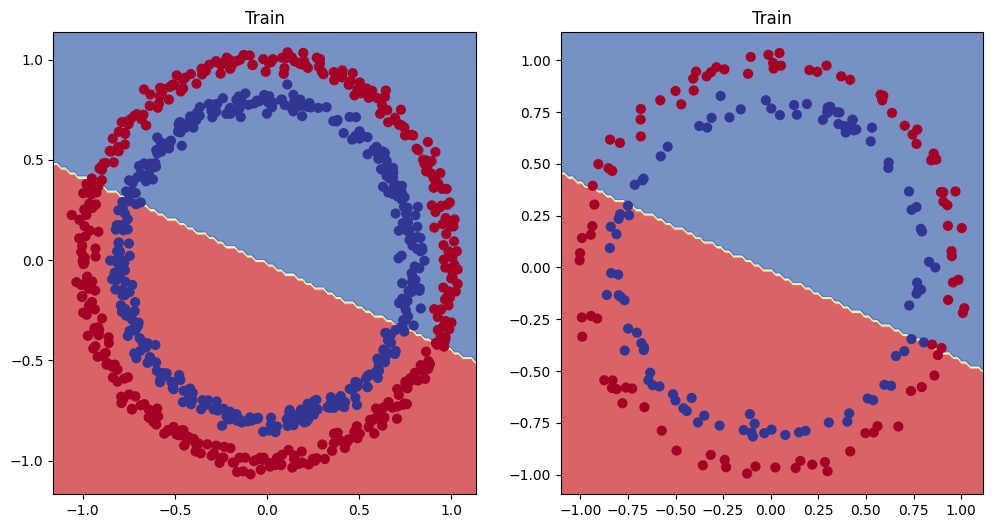

In [67]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Train")
plot_decision_boundary(model_0, X_test, y_test)
